# Let's discover the Higgs boson!

The purpose of this exercise is to reproduce one of the plots used in the discovery of Higgs boson by the CMS experiment. We are going to use public data consisting on proton-proton collisions at 8 TeV collected during 2012, part of the LHC Run 1. This exercise is based on http://opendata.cern.ch/record/5500. 


In the following tasks, we will be able to reproduce the plot for the Higgs discovery in the $pp\rightarrow H \rightarrow ZZ \rightarrow 4l $ channel. This implies that a proton-proton collision in the LHC produces a Higgs boson that decays into two Z bosons that immediately decay into 4 leptons (electrons, muons, or taus), which are the particles we will measure in the final state. 

<div class="center">
<img src="imagenes/higgsdecay.png" width="500"/>
<img src="imagenes/SM_table.png" width="350"/>
</div>

**How are we going to work?** 

**ROOT** (https://root.cern/) is the most common data analysis tool in Particle Physics. It can be used un two languages, C++ and Python. Additionally, several tools have been developed in recent years that allow to work with ROOT files, such as [uproot](https://uproot.readthedocs.io/en/latest/index.html). This tool allows to open ROOT files in python and work with the data using more industry-standard tools, such as numpy or pandas. In our case we will work with [awkward arrays](https://awkward-array.org/doc/main/index.html), similar to numpy but more HEP-oriented.

**Data file structure** 

The ROOT files we will use have the following structure:

<div class="center">
<img src="imagenes/tree.png" width="1000"/>
</div>


- Two **directories**, demo and demoLong. We will only work with demo.
- Inside the demo directory we can find:
    - A **tree** named *'ExampleTree'*. *Trees* are the typical ROOT file structure, where information is stored and classified in **branches**. This structure allows to work with a huge amount of events treating in parallel objects and variables with different dimensions. Our trees store the following variables: 
        - **Number of leptons per event**: *nMuons, nElectrons, nGoodMuons, nGoodElectrons*
        - **Lepton variables**, stored as *arrays* (fixed-size vectors): *ptMuons[nMuons], etaMuons[nMuons], phiMuons[nMuons], chargeMuons[nMuons], idMuons[nMuons], isoMuons[nMuons]*
        - **HZZ candidate variables** in cases with 4 muons: *mass4mu, pt_4mu, eta_4mu, phi_4mu, E4mu, mZa, mZb, selectHZZ*

Before running, let's import some packages that we'll need during the exercise.

In [14]:
from ipywidgets import interact  # interactive widgets
import uproot
import awkward as ak
from matplotlib import pyplot as plt  # plotting
import numba as nb  # just-in-time compilation
import vector  # 4-vectors
import numpy as np

## PART 1: Event selection

In order to start working with ROOT, let's produce a set of basic histograms showing the lepton variable distributions. We will consider simulated **Drell-Yan** events, where a proton-proton collision produces a virtual Z or photon that immediately decays into two same-flavour opposite-charge leptons ($e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$). These events are stored in the `DYJetsToLL_M-50.root` file.

<div class="center">
<img src="imagenes/drellyan.png" width="500"/>
</div>

We will consider for now only muons, but the some procedure could be applied to electrons.

**1) Load the input file and open the tree inside it** 

In [27]:
file = uproot.open('DYJetsToLL_M-50.root')
tree = file['demo/ExampleTree']
branches = tree.arrays()

print(f"Tree has {len(branches)} events")

Tree has 100000 events


**2) What do we have in this tree?**

In [21]:
print(tree.keys())

['nGoodElectrons', 'nGoodMuons', 'nMuons', 'nElectrons', 'ptMuons', 'phiMuons', 'etaMuons', 'chargeMuons', 'idMuons', 'isoMuons', 'ptElectrons', 'phiElectrons', 'etaElectrons', 'chargeElectrons', 'idElectrons', 'isoElectrons', 'selectHZZ', 'mass_4mu', 'pt_4mu', 'eta_4mu', 'phi_4mu', 'E_4mu', 'mZa', 'mZb']


**2) Fill a histogram with the $p_T$ of the muons**

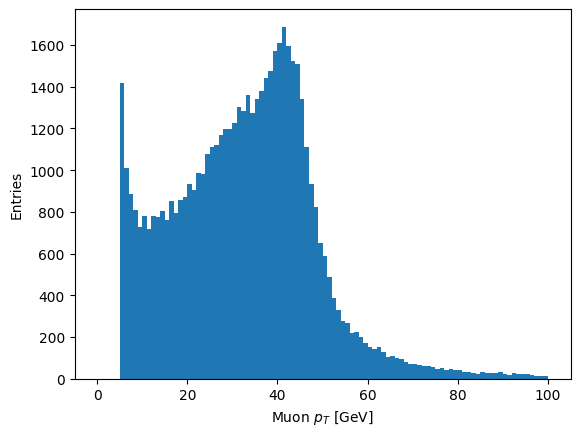

In [16]:
histo_pt = plt.hist(ak.flatten(branches['ptMuons']), bins=100, range=(0, 100))
x_label = plt.xlabel("Muon $p_{T}$ [GeV]")
y_label = plt.ylabel("Entries")

**3) What's happening at very low $p_T$?)**

Some objects (e.g. jets) can be misidentified as muons, and they usually end up reconstructed with very low $p_T$. In order to get rid of this muons, we can apply cuts on variables such as the muon **isolation** and **identification**, produced via dedicated algorithms. Muon isolation (stored in the tree as `isoMuons`) measures how many particles surround the muon, and takes values between 0 and 1. Muon identification (stored as `idMuons`) is the output of an algorithm that applies different cuts to assess whether a muon object can be a proper muon, and takes values 0 or 1.

We can apply cuts on these variables to see how the $p_T$ distribution changes.

In [22]:
def apply_iso_id_cut(branches, iso_cut=0.4, id_cut=0):
    return (branches['isoMuons'] <= iso_cut) & (branches['idMuons'] >= id_cut)

@interact(iso_cut=(0., 1., 0.05), id_cut=(0, 1))
def interactive_straight_track(iso_cut=1.0, id_cut=0):
    mask = apply_iso_id_cut(branches, iso_cut=iso_cut, id_cut=id_cut)
    ax = plt.subplot()
    plt.hist(ak.flatten(branches['ptMuons'][mask]), bins=100, range=(0, 100))
    x_label = plt.xlabel("Muon $p_{T}$ [GeV]")
    y_label = plt.ylabel("Entries")
    plt.text(0.7, 0.9, f'Iso <= {iso_cut}', fontsize=15, transform=ax.transAxes)
    plt.text(0.7, 0.8, f'ID >= {id_cut}', fontsize=15, transform=ax.transAxes)


interactive(children=(FloatSlider(value=1.0, description='iso_cut', max=1.0, step=0.05), IntSlider(value=0, de…

Let's apply an intermediate selection, Identification = 1 and isolation <= 0.4, and plot both distributions (before and after selection) together.

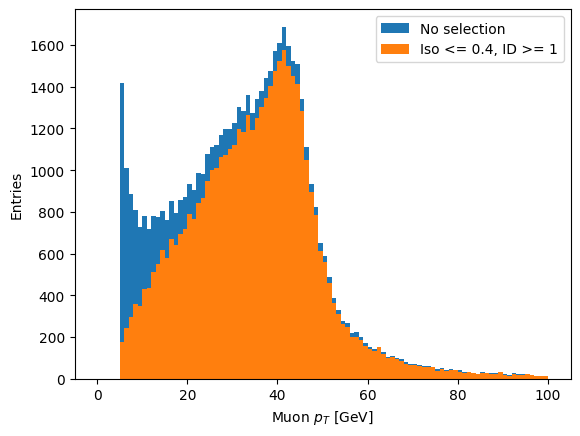

In [5]:
iso_cut = 0.4
id_cut = 1
mask = apply_iso_id_cut(branches, iso_cut=iso_cut, id_cut=id_cut)
ax = plt.subplot()
plt.hist(ak.flatten(branches['ptMuons']), bins=100, range=(0, 100), histtype='barstacked', label="No selection")
plt.hist(ak.flatten(branches['ptMuons'][mask]), bins=100, range=(0, 100), histtype='barstacked', label=f'Iso <= {iso_cut}, ID >= {id_cut}')
x_label = plt.xlabel("Muon $p_{T}$ [GeV]")
y_label = plt.ylabel("Entries")
legend = ax.legend()

How many muons have we lost?

In [6]:
muons_before_selection = len(ak.flatten(branches['ptMuons']))
muons_after_selection = len(ak.flatten(branches['ptMuons'][mask]))

print(f"Muons before selection: {muons_before_selection}")
print(f"Muons after selection:  {muons_after_selection}")

Muons before selection: 55699
Muons after selection:  46803


The number of muons per event with and without this selection are stored in the tree named as `nMuons` and `nGoodMuons`. Let's plot their distributions.

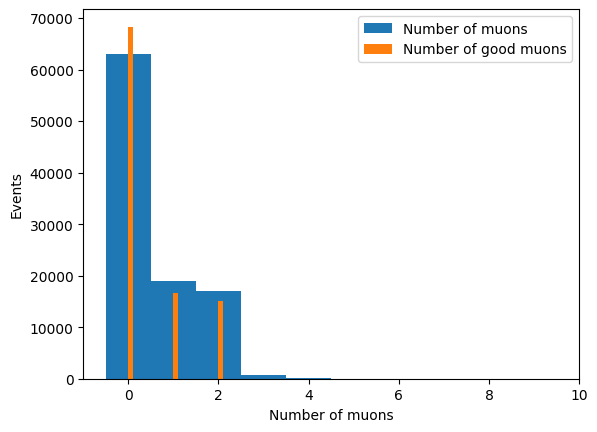

In [7]:
ax = plt.subplot()
plt.hist(branches['nMuons'], bins=10, range=(-0.5, 9.5), histtype='barstacked', label="Number of muons")
plt.hist(branches['nGoodMuons'], bins=100, range=(-0.5, 9.5), histtype='barstacked', label="Number of good muons")
x_label = plt.xlabel("Number of muons")
y_label = plt.ylabel("Events")
legend = ax.legend()

**4) Analyse what you have obtained**

- How are the muons per event?
- How would you characterise them in terms of pt, eta, phi...?
- How many muons are tipically per event? Why?
- What is the effect of the id and isolation cuts?
- Can you run over the other samples and see how these distributions look like?

$\color{red}{\text{You can repeat the same exercise for electrons and see how the results look like.}}$

## Part 2: Invariant mass

As a first test, we will try to obtain the invariant mass of $Z\to\mu\mu$ objects. To do so, we can use `vector.obj` objects, which store the 4-vector of each particle. `vector.obj`'s can be combined, providing an easy way of obtaining the 4-vector of the resulting particles. Additionally, the `vector.obj.mass` attribute stores the mass of that object.

$\color{red}{\text{Goals of this exercise:}}$
- Select the two most energetic good muons per event.
- Build the `vector.obj` object for each of those muons.
- Reconstruct the Z boson and obtain its invariant mass.
    


**1) Load the input file**

In this case, let's work with $H \rightarrow ZZ \rightarrow 4l$ events, stored in `SMHiggsToZZTo4L.root`

In [33]:
higgs_file = uproot.open('SMHiggsToZZTo4L.root')
higgs_tree = higgs_file['demo/ExampleTree']
higgs_branches = higgs_tree.arrays()

higgs_sample_entries = len(higgs_branches)

print(f"Tree has {higgs_sample_entries} events")

Tree has 100000 events


**Obtain the mass from the two most energetic muons**

In [39]:
muon_mass = 0.105658
electron_mass = 0.0005109989

@nb.jit(nopython=True)  # allow just-in-time compilation of the code, making it much faster
def get_mass(builder, branches):
    builder.begin_list()
    for iev in range(len(branches["ptMuons"])):  # looping on all the events of the sample
        # Let's consider that the two muons that come from the Z boson are the most energetic ones (largest pt)
        # How can we select them?
        muon_pts_to_sort = []
        for imuon, pt in enumerate(branches["ptMuons"][iev]):
            # apply selections here if needed, for example the id or isolation cuts we defined before.
            # TODO
            if branches["idMuons"][iev][imuon] < 1 or branches["isoMuons"][iev][imuon] > 0.4:
                continue
            muon_pts_to_sort.append((imuon, pt))
        muon_pts_to_sort.sort(key=lambda x: x[1], reverse=True)
        if len(muon_pts_to_sort) >= 2:
            i1 = muon_pts_to_sort[0][0]
            i2 = muon_pts_to_sort[1][0]

            # The Z boson is a neutral particle -> We can only consider pairs of muons with total charge 0.
            # TODO
            if branches["chargeMuons"][iev][i1] * branches["chargeMuons"][iev][i2] != -1:
                continue
                
            muon1 = vector.obj(
                pt=branches["ptMuons"][iev][i1],
                eta=branches["etaMuons"][iev][i1],
                phi=branches["phiMuons"][iev][i1],
                mass=muon_mass
            )
            muon2 = vector.obj(
                pt=branches["ptMuons"][iev][i2],
                eta=branches["etaMuons"][iev][i2],
                phi=branches["phiMuons"][iev][i2],
                mass=muon_mass
            )
            # how can you compute the mass of the dimuon system?
            dimuon_mass = (muon1 + muon2).mass
            builder.append(dimuon_mass)
    builder.end_list()
    return builder


In [40]:
higgs_sample_mass = get_mass(ak.ArrayBuilder(), higgs_branches).to_list()


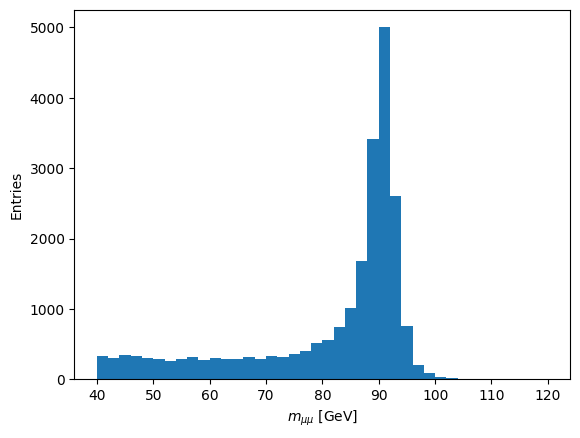

In [41]:
histo_mass = plt.hist(ak.flatten(higgs_sample_mass), bins=40, range=(40, 120))
x_label = plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
y_label = plt.ylabel("Entries")

**2) Some questions you may want to ask yourself**

- If the Z mass is around 91 GeV, why do we see a broader peak?
- Why do we obtain a ~constant tail below 80 GeV?
- What happens if I use a different sample? e.g. `DYJetsToLL_M-50`, the one from the first exercise.
- And for a data sample? The data input file is divided into 10 files (`DoubleMuParkedRun2012BC_X.root`, with `X`$\in[0, 9]$.

Tree has 100000 events


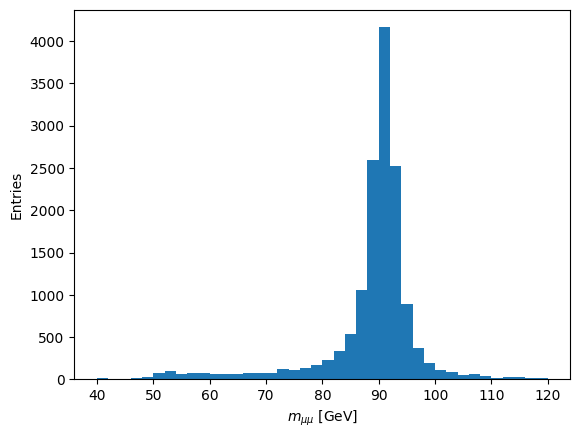

In [42]:
# Running over DYJetsToLL_M-50
# TODO
file = uproot.open('DYJetsToLL_M-50.root')
tree = file['demo/ExampleTree']
branches = tree.arrays()

dy_sample_entries = len(branches)

print(f"Tree has {dy_sample_entries} events")

dy_sample_mass = get_mass(ak.ArrayBuilder(), branches).to_list()
histo_mass = plt.hist(ak.flatten(dy_sample_mass), bins=40, range=(40, 120))
x_label = plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
y_label = plt.ylabel("Entries")

Tree has 6093598 events
Tree has 6093597 events
Tree has 6093598 events
Tree has 6093598 events
Tree has 6093597 events
Tree has 6093598 events
Tree has 6093598 events
Tree has 6093598 events
Tree has 6093597 events
Tree has 6093598 events


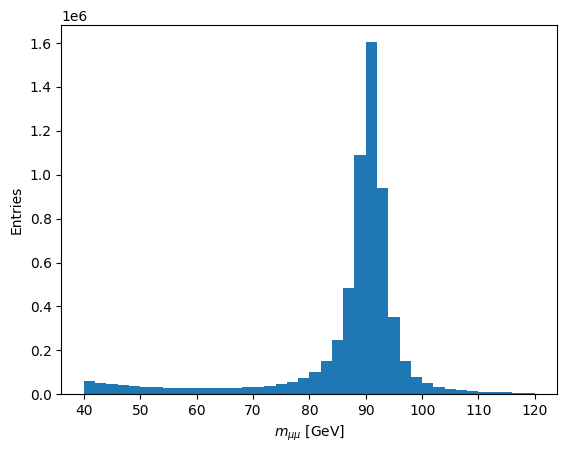

In [43]:
# Running over data

data_sample_mass = []
for i in range(10):
    file = uproot.open(f'DoubleMuParkedRun2012BC_{i}.root')
    tree = file['demo/ExampleTree']
    branches = tree.arrays()

    print(f"Tree has {len(branches)} events")

    data_sample_mass += get_mass(ak.ArrayBuilder(), branches).to_list()
histo_mass = plt.hist(ak.flatten(data_sample_mass), bins=40, range=(40, 120))
x_label = plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
y_label = plt.ylabel("Entries")

In [14]:
# END PART 2

## Part 3: Normalising

Before starting with the Higgs reconstruction we need to learn how to **normalise** histograms, so the the ones obtained from Monte Carlo simulations can be compared to the actual data from the detector. To do so we need to define two quantities

- **Cross section** ($\sigma$), defined as the probability that a given process is given after the collision of the particles. It has units of area (m${}^2$), but in Particle Physics we use the **barn** (1b $ = 10^{-28}$ m${}^2$) and its multiples (mb, pb, fb, ...)
- **Luminosity**: related to the number of events and the cross section as
  $L = \frac{1}{\sigma}\cdot \frac{dN}{dt}$. Intregrating the luminosity in a period of time we obtain the **integrated luminosity**, measured in inversed units of the cross section (pb${}^{-1}$, fb${}^{-1}$, ...). The larger the integrated luminosity, the more data events we will have and the probability that we could have collected enough events of a particular process so it can be statistically observed.

**How do we obtain the values of the cross sections of the different processes?**

Cross sections are computed using appropriated tools, such as [MCFM](https://mcfm.fnal.gov/) or [FEWZ](http://dx.doi.org/10.1103/PhysRevD.86.094034). Their values are estimated considering proton-proton collisions with a center-of-mass energy of 8 TeV.

- $Z\rightarrow\ell^{+}\ell^{-}$, with $m_{ll}>50 GeV$: 1177.3 pb.
- $pp\rightarrow ZZ -> 4\mu$: 7.7 pb.
- $gg\to H\to ZZ \to 4\mu$: 0.0065 pb.


**Let's work!**
Let's compare the event yields after normalization for data (`DoubleMuParkedRun2012BC.root`), signal (`SMHiggsToZZTo4L`), and backgrounds (`DYJetsToLL_M-50` and `ZZTo4mu`) around the Z peak.

Tree has 1499064 events


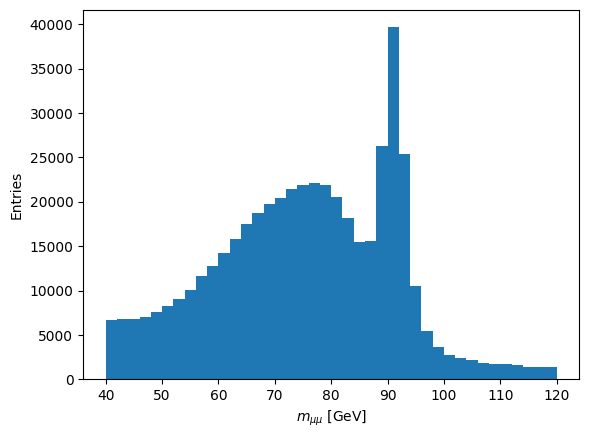

In [44]:
# Running over ZZTo4mu
file = uproot.open('ZZTo4mu.root')
tree = file['demo/ExampleTree']
branches = tree.arrays()

zz_sample_entries = len(branches)

print(f"Tree has {zz_sample_entries} events")

zz_sample_mass = get_mass(ak.ArrayBuilder(), branches).to_list()
histo_mass = plt.hist(ak.flatten(zz_sample_mass), bins=40, range=(40, 120))
x_label = plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
y_label = plt.ylabel("Entries")

In [45]:
integrated_luminosity = 11580 #pb-1
hzzXsec = 0.0065 # xs gg-> H -> ZZ -> 4mu [pb]
zzXsec = 0.077 * 1.386  # xs gg -> ZZ -> 4mu [pb]
dyM50Xsec = 1177.3 * 3 # xs gg -> Z -> mumu [pb]

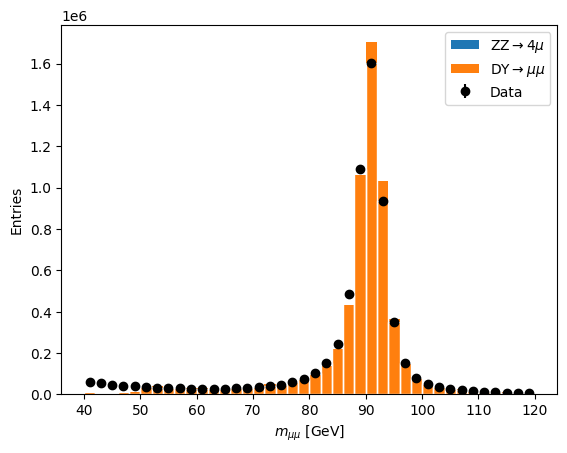

In [48]:
ax = plt.subplot()
stacked_histo = plt.hist(
    [ak.flatten(zz_sample_mass), ak.flatten(dy_sample_mass)],
    bins=40, range=(40, 120),
    stacked=True,
    label=[r"ZZ$\to 4 \mu$", r"DY$ \to \mu \mu $"],
    weights=[(integrated_luminosity * zzXsec / zz_sample_entries) * np.ones_like(ak.flatten(zz_sample_mass)),
             (integrated_luminosity * dyM50Xsec / dy_sample_entries) * np.ones_like(ak.flatten(dy_sample_mass))]
)

data = plt.hist(
    ak.flatten(data_sample_mass),
    bins=40, range=(40, 120),
    fill=False,
    edgecolor="white"
)
bin_centres = (data[1][:-1] + data[1][1:])/2.
error = np.sqrt(data[0])
data = plt.errorbar(bin_centres, data[0], yerr=error, fmt='o', color="k", label="Data")

x_label = plt.xlabel(r"$m_{\mu\mu}$ [GeV]")
y_label = plt.ylabel("Entries")
legend = plt.legend()
#ax.set_yscale('log')

**2) Some questions you may want to ask yourself**

- What do you think about the agreement between data and simulation?
- Where is the $ZZ\to4\mu$ distribution?
- How does the Higgs sample compare to these distributions?

# Now we can look for the Higgs boson!

We have already all the tools needed to reproduce the plot used in the search for $H\to ZZ \to 4l$. We will simplify it a bit by only looking at the $2\mu2e$ channel and only part of the 2012 data. A more detailed version of this analysis is located in https://github.com/cms-opendata-analyses/HiggsExample20112012, where you can see the final plot:

<div>
<img src="imagenes/mass4l_combine.png" width="800"/>
</div>

In our particular channel, the plot looks like 

<div>
<img src="imagenes/mass2mu2e_small.png" width="800"/>
</div>

$\color{red}{\text{Goals of this exercise}}$
- Select the two most energetic muons and electrons per event
- Reconstruct both Z bosons and the Higgs boson!
- Compare signal, background, and data
    
We will consider three samples:
- Monte Carlo simulation of $pp \to H \to ZZ \to 4l$: file `SMHiggsToZZTo4l.root`
- Monte Carlo simulation of $pp \to ZZ \to 2\mu2e$: file `ZZTo2mu2e.root`
- 2012 data: files `DoubleMuParkedRun2012BC_X.root`


### Some constants that will be needed for this exercise

In [51]:
muon_mass = 0.105658
electron_mass = 0.0005109989
Z_mass = 91.1876

# Luminosity
integrated_luminosity = 11580 # pb-1

# Cross-sections :
hzzXsec = 0.0065 # pb. gg -> H -> ZZ -> 4l
zzXsec = 0.18 * 1.386  #pb. gg -> ZZ -> 4l

### 2) Look for the two muons and two electrons

Let's work with ```ROOT.TLorentzVector``` as in the previous exercise. We'll build the TLorentzVector for each muon and electron, sum them to obtain the 4-vectors of each $Z$ and sum them again to reconstruct the Higgs boson. 

Let's start by not applying any additional selection, just reconstruct both $Z$ from the two most energetic electrons and muons. These electrons and muons must be *good*, i.e. satisfy the requirements on ID and isolation already considered in the previous exercises.



In [52]:
@nb.jit(nopython=True)
def get_higgs_mass_nosel(builder, branches):
    builder.begin_list()
    for iev in range(len(branches["ptMuons"])):  # looping on all the events of the sample
        # if iev % 1000 == 0:
        #     print(iev)

        # TODO: Select the appropriate muons and electrons and sort them by pt
        # sort muons by pt
        muon_pts_to_sort = []
        for imuon, pt in enumerate(branches["ptMuons"][iev]):
            # apply selections here if needed
            if branches["idMuons"][iev][imuon] < 1 or branches["isoMuons"][iev][imuon] > 0.4:
                continue
            muon_pts_to_sort.append((imuon, pt))
        muon_pts_to_sort.sort(key=lambda x: x[1], reverse=True)

        # sort electrons by pt
        electron_pts_to_sort = []
        for iele, pt in enumerate(branches["ptElectrons"][iev]):
            # apply selections here if needed
            if branches["idElectrons"][iev][iele] < 1 or branches["isoElectrons"][iev][iele] > 0.4:
                continue
            electron_pts_to_sort.append((iele, pt))
        electron_pts_to_sort.sort(key=lambda x: x[1], reverse=True)

        if len(muon_pts_to_sort) >= 2 and len(electron_pts_to_sort) >= 2:
            # Build muons and electrons
            i1 = muon_pts_to_sort[0][0]
            i2 = muon_pts_to_sort[1][0]

            if branches["chargeMuons"][iev][i1] * branches["chargeMuons"][iev][i2] != -1:
                continue

            muon1 = vector.obj(
                pt=branches["ptMuons"][iev][i1],
                eta=branches["etaMuons"][iev][i1],
                phi=branches["phiMuons"][iev][i1],
                mass=muon_mass
            )
            muon2 = vector.obj(
                pt=branches["ptMuons"][iev][i2],
                eta=branches["etaMuons"][iev][i2],
                phi=branches["phiMuons"][iev][i2],
                mass=muon_mass
            )

            i1 = electron_pts_to_sort[0][0]
            i2 = electron_pts_to_sort[1][0]

            if branches["chargeElectrons"][iev][i1] * branches["chargeElectrons"][iev][i2] != -1:
                continue

            electron1 = vector.obj(
                pt=branches["ptElectrons"][iev][i1],
                eta=branches["etaElectrons"][iev][i1],
                phi=branches["phiElectrons"][iev][i1],
                mass=electron_mass
            )
            electron2 = vector.obj(
                pt=branches["ptElectrons"][iev][i2],
                eta=branches["etaElectrons"][iev][i2],
                phi=branches["phiElectrons"][iev][i2],
                mass=electron_mass
            )

            # Build the Z's and the Higgs boson
            Zmumu = muon1 + muon2
            Zee = electron1 + electron2
            H = Zmumu + Zee

            builder.append(H.mass)
    builder.end_list()
    return builder

In [53]:
file = uproot.open('SMHiggsToZZTo4L.root')
tree = file['demo/ExampleTree']
branches = tree.arrays()

higgs_sample_entries = len(branches)

print(f"Tree has {higgs_sample_entries} events")

Tree has 100000 events


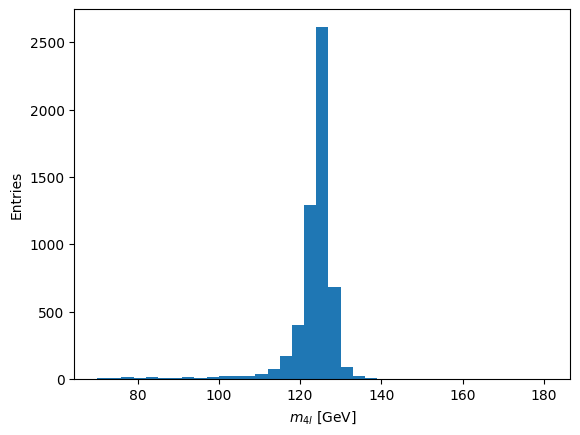

In [54]:
higgs_sample_mass = get_higgs_mass_nosel(ak.ArrayBuilder(), branches).to_list()
histo_mass = plt.hist(ak.flatten(higgs_sample_mass), bins=37, range=(70, 181))
x_label = plt.xlabel(r"$m_{4l}$ [GeV]")
y_label = plt.ylabel("Entries")

### 3) Is that all?

No! We can try to improve the signal sensitivity by applying a selection based on the Higgs topology. 

Given that $m_H < 2 \cdot m_Z$, we need to look for events where one of the $Z$ bosons is produced on-shell and the other off-shell, i.e. outside the resonance. Then, we will require that the $Z$ boson with a mass closer to the nominal $Z$ mass has a mass within 40 and 120 GeV, and the off-shell $Z$ between 12 and 120 GeV. On top of that, we will require that the leptons coming from the on-shell $Z$ have $p_T$ of at least 20 and 10 GeV.

In [55]:
@nb.jit(nopython=True)
def get_higgs_mass_withsel(builder, branches):
    builder.begin_list()
    for iev in range(len(branches["ptMuons"])):  # looping on all the events of the sample
        # if iev % 1000 == 0:
        #     print(iev)

        # sort muons by pt
        muon_pts_to_sort = []
        for imuon, pt in enumerate(branches["ptMuons"][iev]):
            # apply selections here if needed
            if branches["idMuons"][iev][imuon] < 1 or branches["isoMuons"][iev][imuon] > 0.4:
                continue
            muon_pts_to_sort.append((imuon, pt))
        muon_pts_to_sort.sort(key=lambda x: x[1], reverse=True)

        # sort electrons by pt
        electron_pts_to_sort = []
        for iele, pt in enumerate(branches["ptElectrons"][iev]):
            # apply selections here if needed
            if branches["idElectrons"][iev][iele] < 1 or branches["isoElectrons"][iev][iele] > 0.4:
                continue
            electron_pts_to_sort.append((iele, pt))
        electron_pts_to_sort.sort(key=lambda x: x[1], reverse=True)

        if len(muon_pts_to_sort) >= 2 and len(electron_pts_to_sort) >= 2:
            # Build muons and electrons
            i1 = muon_pts_to_sort[0][0]
            i2 = muon_pts_to_sort[1][0]

            if branches["chargeMuons"][iev][i1] * branches["chargeMuons"][iev][i2] != -1:
                continue

            muon1 = vector.obj(
                pt=branches["ptMuons"][iev][i1],
                eta=branches["etaMuons"][iev][i1],
                phi=branches["phiMuons"][iev][i1],
                mass=muon_mass
            )
            muon2 = vector.obj(
                pt=branches["ptMuons"][iev][i2],
                eta=branches["etaMuons"][iev][i2],
                phi=branches["phiMuons"][iev][i2],
                mass=muon_mass
            )

            i1 = electron_pts_to_sort[0][0]
            i2 = electron_pts_to_sort[1][0]

            if branches["chargeElectrons"][iev][i1] * branches["chargeElectrons"][iev][i2] != -1:
                continue

            electron1 = vector.obj(
                pt=branches["ptElectrons"][iev][i1],
                eta=branches["etaElectrons"][iev][i1],
                phi=branches["phiElectrons"][iev][i1],
                mass=electron_mass
            )
            electron2 = vector.obj(
                pt=branches["ptElectrons"][iev][i2],
                eta=branches["etaElectrons"][iev][i2],
                phi=branches["phiElectrons"][iev][i2],
                mass=electron_mass
            )

            # Build the Z's and the Higgs boson
            Zmumu = muon1 + muon2
            Zee = electron1 + electron2
            H = Zmumu + Zee

            if abs(Zmumu.mass - Z_mass) < abs(Zee.mass - Z_mass):  # Z1 = Zmumu
                # Require that the two muons have pts > 20 and > 10 GeV
                if muon1.pt > 20 and muon2.pt > 10: # Require that the two muons have pts > 20 and > 10 GeV
                    if Zmumu.mass > 40 and Zmumu.mass < 120 and Zee.mass > 12 and Zee.mass < 120: # Selection on the on-shell (Zmumu) and off-shell (Zee) Zs
                        builder.append(H.mass)
            else:  # Z1 = Zee
                # Require that the two electrons have pts > 20 and > 10 GeV
                if electron1.pt > 20 and electron2.pt > 10 :
                    if Zee.mass > 40 and Zee.mass < 120 and Zmumu.mass > 12 and Zmumu.mass < 120: # Selection on the on-shell (Zee) and off-shell (Zmumu) Zs
                        builder.append(H.mass)
    builder.end_list()
    return builder

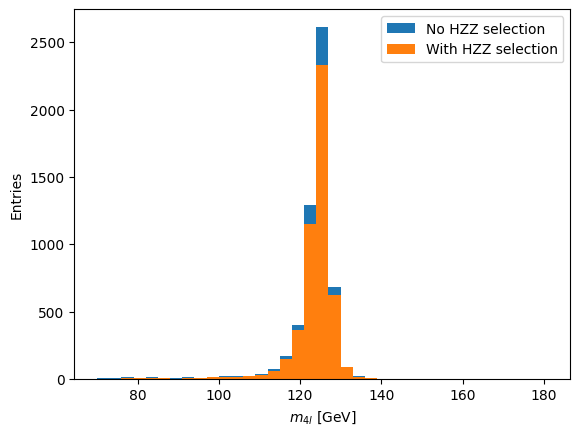

In [56]:
higgs_sample_mass_sel = get_higgs_mass_withsel(ak.ArrayBuilder(), branches).to_list()
histo_mass = plt.hist(ak.flatten(higgs_sample_mass), bins=37, range=(70, 181), histtype='barstacked', label="No HZZ selection")
histo_mass_sel = plt.hist(ak.flatten(higgs_sample_mass_sel), bins=37, range=(70, 181), histtype='barstacked', label="With HZZ selection")
x_label = plt.xlabel(r"$m_{4l}$ [GeV]")
y_label = plt.ylabel("Entries")
legend = plt.legend()

### 4) What has been the effect on the signal?

Didn't affect it much. But what about the background? Produce the same histograms running on the ZZ background sample

In [57]:
file = uproot.open('ZZTo2mu2e.root')
tree = file['demo/ExampleTree']
branches = tree.arrays()
zz_sample_entries = len(branches)

print(f"Tree has {zz_sample_entries} events")

Tree has 100000 events


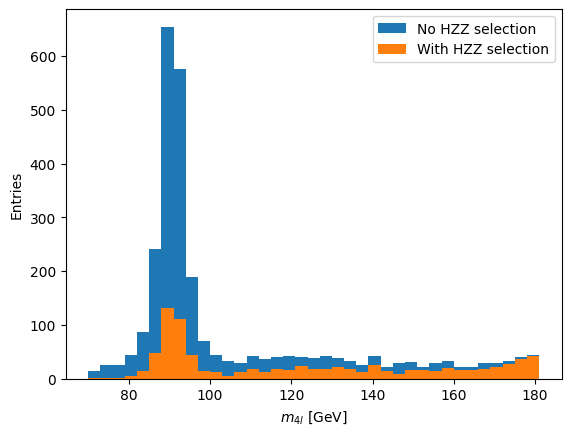

In [58]:
zz_sample_mass = get_higgs_mass_nosel(ak.ArrayBuilder(), branches).to_list()
zz_sample_mass_sel = get_higgs_mass_withsel(ak.ArrayBuilder(), branches).to_list()
histo_mass = plt.hist(ak.flatten(zz_sample_mass), bins=37, range=(70, 181), histtype='barstacked', label="No HZZ selection")
histo_mass_sel = plt.hist(ak.flatten(zz_sample_mass_sel), bins=37, range=(70, 181), histtype='barstacked', label="With HZZ selection")
x_label = plt.xlabel(r"$m_{4l}$ [GeV]")
y_label = plt.ylabel("Entries")
legend = plt.legend()

### 5) Let's get the final plot!

Normalise each MC process to its cross section and plot them together with the data.

In [59]:
data_sample_mass_sel = []
for i in range(10):
    file = uproot.open(f'DoubleMuParkedRun2012BC_{i}.root')
    tree = file['demo/ExampleTree']
    branches = tree.arrays()

    print(f"Tree has {len(branches)} events")

    data_sample_mass_sel += get_higgs_mass_withsel(ak.ArrayBuilder(), branches).to_list()

Tree has 6093598 events
Tree has 6093597 events
Tree has 6093598 events
Tree has 6093598 events
Tree has 6093597 events
Tree has 6093598 events
Tree has 6093598 events
Tree has 6093598 events
Tree has 6093597 events
Tree has 6093598 events


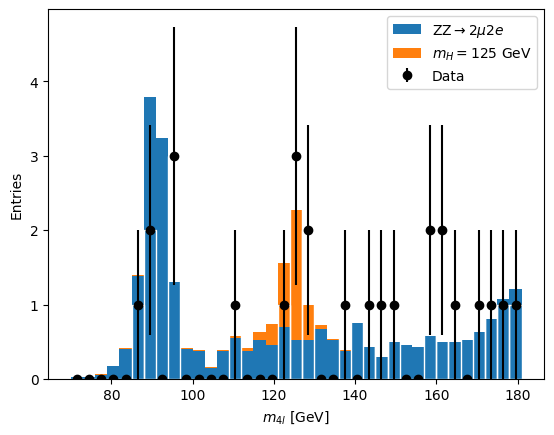

In [60]:
stacked_histo = plt.hist(
    [ak.flatten(zz_sample_mass_sel), ak.flatten(higgs_sample_mass_sel)],
    bins=37, range=(70, 181),
    stacked=True,
    label=[r"ZZ$\to 2 \mu 2e$", r"$m_{H} = 125$ GeV"],
    weights=[(integrated_luminosity * zzXsec / zz_sample_entries) * np.ones_like(ak.flatten(zz_sample_mass_sel)),
             (integrated_luminosity * hzzXsec / higgs_sample_entries) * np.ones_like(ak.flatten(higgs_sample_mass_sel))]
)

data = plt.hist(
    ak.flatten(data_sample_mass_sel),
    bins=37, range=(70, 181),
    fill=False,
    edgecolor="white"
)
bin_centres = (data[1][:-1] + data[1][1:])/2.
error = np.sqrt(data[0])
data = plt.errorbar(bin_centres, data[0], yerr=error, fmt='o', color="k", label="Data")

x_label = plt.xlabel(r"$m_{4l}$ [GeV]")
y_label = plt.ylabel("Entries")
legend = plt.legend()

# Congratulations! You have discovered the Higgs boson!
You can now repeat the same exercise in the $H\to ZZ\to4\mu$ channel